<a href="https://colab.research.google.com/github/Mhmmd-Mhmmd/Quera_questions/blob/main/09_skimlit_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Replicating SKimLit paper
[here](arxiv.org/1612.05251.pdf)

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!echo "------------------------------------------------------------"
!ls pubmed-rct -lh

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 42.73 MiB/s, done.
Resolving deltas: 100% (12/12), done.
------------------------------------------------------------
total 20K
drwxr-xr-x 2 root root 4.0K Oct 24 06:33 PubMed_200k_RCT
drwxr-xr-x 2 root root 4.0K Oct 24 06:33 PubMed_200k_RCT_numbers_replaced_with_at_sign
drwxr-xr-x 2 root root 4.0K Oct 24 06:33 PubMed_20k_RCT
drwxr-xr-x 2 root root 4.0K Oct 24 06:33 PubMed_20k_RCT_numbers_replaced_with_at_sign
-rw-r--r-- 1 root root 2.4K Oct 24 06:33 README.md


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix

In [ ]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt"
file_names = [data_dir + file for file in os.listdir('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/')]
file_names

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txttrain.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txttest.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txtdev.txt']

In [ ]:
!nvidia-smi

Mon Oct 23 08:08:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Preprocessing
and visualisation

In [ ]:
def get_lines(file_name: str) -> list:
    with open(file=file_name, mode='r', encoding='utf8') as f_in:
        lines = f_in.readlines()
    return lines

In [ ]:
def preprocess_text_with_line_numbers(filename):
    with open(file=filename, mode='r', encoding='utf8') as f_in:
        input_lines = f_in.readlines()
    # input_lines = get_lines(filename)

    abstract_lines = "" # create an empty abstract
    abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
    for line in input_lines:
        if line.startswith("###"): # check to see if line is an ID line
            abstract_id = line
            abstract_lines = "" # reset abstract string
        elif line.isspace(): # check to see if line is a new line
            abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

            # Iterate through each line in abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # create empty dict to store data from line
                target_text_split = abstract_line.split("\t") # split target label from text
                line_data["target"] = target_text_split[0] # get target label
                line_data["text"] = target_text_split[1].lower() # get target text and lower it
                line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
                line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
                abstract_samples.append(line_data) # add line data to abstract samples list

        else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
            abstract_lines += line

    return abstract_samples

In [ ]:
%%time
train_samples = preprocess_text_with_line_numbers('pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt')
valid_samples = preprocess_text_with_line_numbers('pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt')
test_samples  = preprocess_text_with_line_numbers('pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt')

print(len(train_samples), len(valid_samples), len(test_samples))

180040 30212 30135
CPU times: user 367 ms, sys: 78.1 ms, total: 445 ms
Wall time: 456 ms


In [ ]:
train_data = pd.DataFrame(train_samples)
valid_data = pd.DataFrame(valid_samples)
test_data  = pd.DataFrame(test_samples)

In [ ]:
train_data['target'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

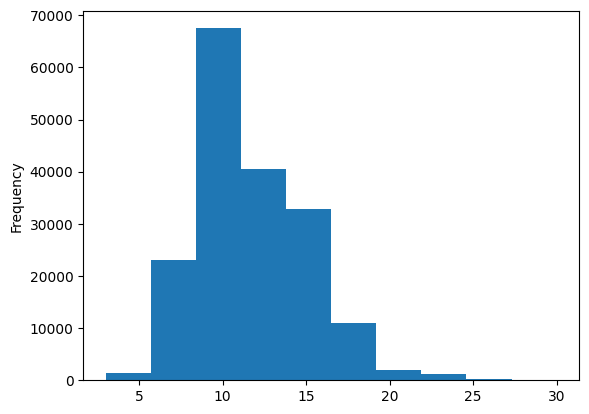

In [ ]:
train_data['total_lines'].plot.hist();

In [ ]:
train_sents = train_data['text'].to_numpy()
valid_sents = valid_data['text'].to_numpy()
test_sents = test_data['text'].to_numpy()

train_sents.shape

(180040,)

In [ ]:
encoder = OneHotEncoder(sparse_output=False)

train_labels = encoder.fit_transform(train_data['target'].to_numpy().reshape(-1, 1))
valid_labels = encoder.transform(valid_data['target'].to_numpy().reshape(-1, 1))
test_labels = encoder.transform(test_data['target'].to_numpy().reshape(-1, 1))

train_labels.shape

(180040, 5)

In [ ]:
l_encoder = LabelEncoder()
class_names = l_encoder.fit(train_data['target'].to_numpy()).classes_
num_classes = len(class_names)

train_labels_enc = l_encoder.fit_transform(train_data['target'].to_numpy())
valid_labels_enc = l_encoder.transform(valid_data['target'].to_numpy())
test_labels_enc = l_encoder.transform(test_data['target'].to_numpy())

## Experiments
* Model 0: Baseline (Naive Bayes with TF-IDF)
* Model 1: Conv1D with token embedding
* Model 2: TensorFlow Hub pretrained feature extractor
* Model 3: Connv1D with character embedding
* Model 4: Pre-trained token embedding (same as 2) with character embedding (same as 3)
* Model 5: Pre-trained token embedding + character embedding + positional embeddings

In [ ]:
def evaluation(y_true, y_pred) -> dict:
    res = {}
    res["acc"] = accuracy_score(y_true, y_pred)
    res["recall"] = recall_score(y_true, y_pred, average='weighted')
    res["precision"] = precision_score(y_true, y_pred, average='weighted')
    res["f1"] = f1_score(y_true, y_pred, average='weighted')

    print('-' * 50)
    print(f"accuracy: {res['acc']:.4}, recall: {res['recall']:.4}, precision: {res['precision']:.4}, f1: {res['f1']:.4}\n")

    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))

    return res

### Model 0: Baseline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, CategoricalNB

In [ ]:
# %%time
vectorizer = TfidfVectorizer(stop_words='english')

model_0 = Pipeline(steps=[('tfidf', TfidfVectorizer()),
                          ('clf', MultinomialNB())],
                   verbose=True)

model_0.fit(train_sents, train_labels_enc,)

y_pred = model_0.predict(valid_sents)

result_model_0 = evaluation(valid_labels_enc, y_pred)

[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   3.2s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.1s
--------------------------------------------------
accuracy: 0.7218, recall: 0.7218, precision: 0.7186, f1: 0.6989

              precision    recall  f1-score   support

           0       0.66      0.49      0.56      3449
           1       0.65      0.59      0.61      4582
           2       0.72      0.87      0.79      9964
           3       0.75      0.14      0.23      2376
           4       0.76      0.86      0.81      9841

    accuracy                           0.72     30212
   macro avg       0.71      0.59      0.60     30212
weighted avg       0.72      0.72      0.70     30212

[[1683  794  694   97  181]
 [ 244 2687  432    5 1214]
 [ 116   75 8670    7 1096]
 [ 505  422  978  325  146]
 [  20  181 1196    1 8443]]


### Model 1: Conv1D with token embedding

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sents, train_labels))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_sents, valid_labels))
test_dataset  = tf.data.Dataset.from_tensor_slices((test_sents,  test_labels))

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset  = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
ave_len = int(tf.reduce_mean([len(line.split()) for line in train_sents]))
ave_len

26

In [ ]:
optim_len = int(np.percentile([len(line.split()) for line in train_sents], q=95))

In [ ]:
vectorization_layer = keras.layers.TextVectorization(max_tokens=1000,
                                                     output_sequence_length=optim_len,
                                                     pad_to_max_tokens=True)
vectorization_layer.adapt(train_sents)

In [ ]:
inputs = keras.layers.Input(shape=(1,), dtype=tf.string)
x = vectorization_layer(inputs)
x = keras.layers.Embedding(input_dim=1000, output_dim=512, input_length=optim_len)(x)
x = keras.layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(x)
x = keras.layers.GlobalAveragePooling1D()(x)
outputs = keras.layers.Dense(units=num_classes, activation='softmax')(x)

model_1 = keras.Model(inputs, outputs, name='model_1')

model_1.compile(loss=keras.losses.CategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics='accuracy')

model_1.summary()

history_model_1 = model_1.fit(train_dataset,
                              validation_data=valid_dataset,
                              callbacks=[keras.callbacks.ModelCheckpoint(filepath='checkpoints/model_1.ckpt',
                                                                         save_best_only=True),
                                         keras.callbacks.TensorBoard(log_dir='logs/model_1',
                                                                     write_images=True)],
                              epochs=5)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 55, 512)           512000    
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            163904    
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 5)                 325 

In [ ]:
evaluation(test_labels, model_1.predict(test_sents))

942/942 [==============================] - 3s 3ms/step


ValueError: ignored

In [ ]:
model_1.evaluate(test_dataset)

942/942 [==============================] - 4s 4ms/step - loss: 0.5722 - accuracy: 0.7901


[0.5721787214279175, 0.7900779843330383]

### Model 2: TensorFlow Hub pretrained feature extractor

In [ ]:
import tensorflow_hub as hub

In [ ]:
transfer_embedding_layer = hub.KerasLayer(handle="https://tfhub.dev/google/universal-sentence-encoder/4",
                                          input_shape=[],
                                          dtype=tf.string,
                                          trainable=False,
                                          name="USE_layer")

In [ ]:
inputs = keras.layers.Input(shape=(), dtype=tf.string)
x = transfer_embedding_layer(inputs)
x = keras.layers.Dense(units=128, activation='relu')(x)
outputs = keras.layers.Dense(units=num_classes, activation='softmax')(x)

model_2 = keras.Model(inputs, outputs, name='model_2')

model_2.compile(loss=keras.losses.CategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics='accuracy')

model_2.summary()

history_model_2 = model_2.fit(train_dataset,
                              validation_data=valid_dataset,
                              callbacks=[keras.callbacks.ModelCheckpoint(filepath='checkpoints/model_2.ckpt',
                                                                         save_best_only=True),
                                         keras.callbacks.TensorBoard(log_dir='logs/model_2',
                                                                     write_images=True)],
                              epochs=5)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 USE_layer (KerasLayer)      (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________
Epoch 1/5
5627/5627 [==============================] - 95s 16ms/step - loss: 0.7275 - accuracy: 0.7223 - val_loss: 0.6567 - val_accuracy: 0.7

### Model 3: Conv1D with Character embedding

In [ ]:
# making a func to do character level embedding
def split_chars(text: str):
    return " ".join(list(text))

In [ ]:
split_chars('mahsa davarmanesh')

'm a h s a   d a v a r m a n e s h'

In [ ]:
train_chars = [split_chars(sent) for sent in train_sents]
valid_chars = [split_chars(sent) for sent in valid_sents]
test_chars  = [split_chars(sent) for sent in test_sents]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
ave_char_len = int(sum([len(i) for i in train_sents]) / len(train_sents))
ave_char_len

149

In [ ]:
optim_len_char = int(np.percentile(a=[len(i) for i in train_sents], q=95))

In [ ]:
# getting all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet, len(alphabet)

('abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 68)

In [ ]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # for space and OOV character (in our chase  called UNK)

In [ ]:
char_vectorizer = tf.keras.layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                                    output_sequence_length=ave_char_len,
                                                    pad_to_max_tokens=True,
                                                    name="char_vectorizer_layer") # if we want to consider the puncs we shall change the "standarize"
char_vectorizer.adapt(train_chars)

In [ ]:
# checking char vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(char_vocab)

['', '[UNK]', 'e', 't', 'i', 'a', 'n', 'o', 'r', 's', 'd', 'c', 'l', 'h', 'p', 'm', 'u', 'f', 'g', 'y', 'w', 'v', 'b', 'k', 'x', 'z', 'q', 'j']


In [ ]:
train_dataset_char = tf.data.Dataset.from_tensor_slices((train_chars, train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset_char = tf.data.Dataset.from_tensor_slices((valid_chars, valid_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset_char  = tf.data.Dataset.from_tensor_slices((test_chars, test_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
inputs = keras.layers.Input(shape=(), dtype=tf.string)
x = char_vectorizer(inputs)
x = keras.layers.Embedding(input_dim=len(char_vocab),
                           output_dim=25,
                           # input_length=ave_char_len,
                           mask_zero=True)(x)
x = keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
x = keras.layers.GlobalMaxPooling1D()(x)
outputs = keras.layers.Dense(units=num_classes, activation='softmax')(x)

model_3 = keras.Model(inputs, outputs, name='model_3')

model_3.compile(loss=keras.losses.CategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics='accuracy')

model_3.summary()

history_model_3 = model_3.fit(train_dataset_char,
                              validation_data=valid_dataset_char,
                              workers=os.cpu_count(),
                              callbacks=[keras.callbacks.ModelCheckpoint(filepath='checkpoints/model_3.ckpt',
                                                                         save_best_only=True),
                                         keras.callbacks.TensorBoard(log_dir='logs/model_3',
                                                                     write_images=True)],
                              epochs=5)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 char_vectorizer_layer (Tex  (None, 149)               0         
 tVectorization)                                                 
                                                                 
 embedding_1 (Embedding)     (None, 149, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 149, 64)           4864      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

In [ ]:
y_pred = tf.argmax(model_3.predict(test_chars), axis=1).numpy()
print(y_pred)

942/942 [==============================] - 4s 4ms/step
[2 2 2 ... 4 4 1]


In [ ]:
evaluation(test_labels.argmax(axis=1), y_pred)

--------------------------------------------------
accuracy: 0.6805, recall: 0.6805, precision: 0.6711, f1: 0.6704

              precision    recall  f1-score   support

           0       0.54      0.46      0.50      3621
           1       0.56      0.49      0.52      4571
           2       0.77      0.77      0.77      9897
           3       0.57      0.33      0.42      2333
           4       0.70      0.84      0.76      9713

    accuracy                           0.68     30135
   macro avg       0.63      0.58      0.59     30135
weighted avg       0.67      0.68      0.67     30135

[[1661  793  475  362  330]
 [ 560 2260  393  107 1251]
 [ 205  186 7619  102 1785]
 [ 564  431  363  770  205]
 [  68  378 1058   11 8198]]


{'acc': 0.6805375808860129,
 'recall': 0.6805375808860129,
 'precision': 0.671109355379929,
 'f1': 0.6703596443773496}

### Model 4: Pre-trained token embedding (same as 2) with character embedding (same as 3)

steps to do so:
1. creating a token-level embedding model (similiar to `model_1`)
2. creating a character-lavel embedding model (similiar to `model_3`) with some slight modifications
3. combining previous models using a concatinate layer (`keras.layers.Concatinate`)
4. building a series of output layers on top of previous layer similar to Figure 1 of the paper
5. constructing a model to take token-lavel and character-level sequences as input and produces label probabilities as output


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input_layer (InputLay  [(None,)]                    0         []                            
 er)                                                                                              
                                                                                                  
 token_input_layer (InputLa  [(None,)]                    0         []                            
 yer)                                                                                             
                                                                                                  
 char_vectorizer_layer (Tex  (None, 149)                  0         ['char_input_layer[0][0]']    
 tVectorization)                                                                            

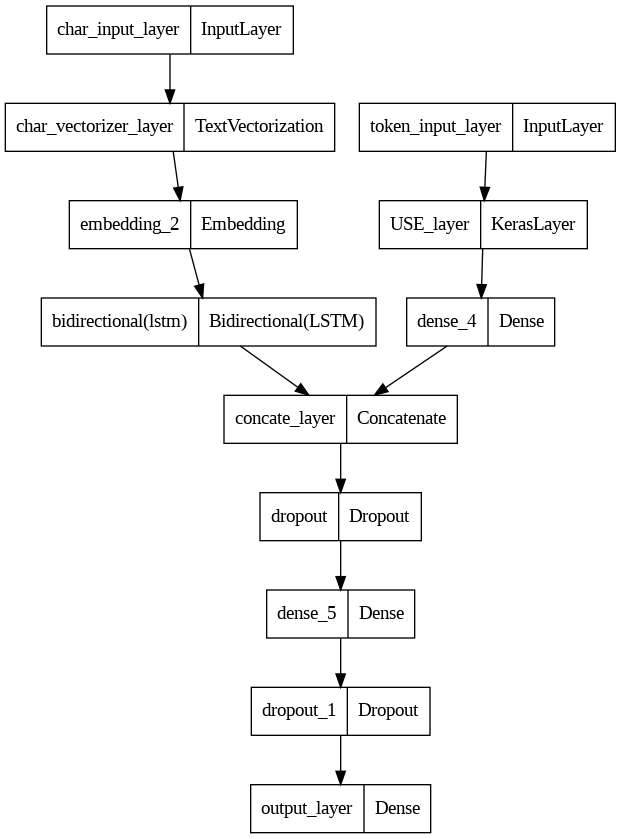

In [ ]:
# 1. token-level model
token_inputs = keras.layers.Input(shape=(), dtype=tf.string, name='token_input_layer')
x = transfer_embedding_layer(token_inputs)
token_outputs = keras.layers.Dense(units=128, activation='relu')(x)

token_model = keras.Model(inputs=token_inputs, outputs=token_outputs, name='token_embedding_model')

# 2. char-level model
char_inputs = keras.layers.Input(shape=(), dtype=tf.string, name='char_input_layer')
x = char_vectorizer(char_inputs)
x = keras.layers.Embedding(input_dim=len(char_vocab),
                           output_dim=25,
                           mask_zero=True)(x)
char_outputs = keras.layers.Bidirectional(layer=keras.layers.LSTM(units=32))(x)

char_model = keras.Model(inputs=char_inputs, outputs=char_outputs, name='char_model_bi_lstm')

# 3. concate
concate_layer = keras.layers.Concatenate(name='concate_layer')([token_model.output,
                                                                char_model.output])
# 4. creating output layer
dropout_layer = keras.layers.Dropout(rate=0.5)(concate_layer)
x = keras.layers.Dense(units=128, activation='relu')(dropout_layer)
x = keras.layers.Dropout(rate=0.5)(x)
outputs = keras.layers.Dense(units=num_classes, activation='softmax', name='output_layer')(x)

# conctructing
model_4 = keras.Model(inputs=[token_model.input,
                              char_model.input],
                      outputs=outputs,
                      name='model_4')

model_4.compile(loss=keras.losses.CategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics='accuracy')

model_4.summary()

keras.utils.plot_model(model_4,)

# history_model_4 = model_4.fit()

In [ ]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sents, train_chars)) # the order must be same as inputs argument of tf.keras.Model
train_char_token_label = tf.data.Dataset.from_tensor_slices(train_labels)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_label)).batch(32).prefetch(tf.data.AUTOTUNE)

valid_char_token_dataset = tf.data.Dataset.zip((
                                tf.data.Dataset.from_tensor_slices((valid_sents, valid_chars)),
                                tf.data.Dataset.from_tensor_slices(valid_labels))).batch(32).prefetch(tf.data.AUTOTUNE)

test_char_token_dataset = tf.data.Dataset.zip((
                                tf.data.Dataset.from_tensor_slices((test_sents, test_chars)),
                                tf.data.Dataset.from_tensor_slices(test_labels))).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
history_model_4 = model_4.fit(train_char_token_dataset,
                              validation_data=valid_char_token_dataset,
                              callbacks=[keras.callbacks.ModelCheckpoint(filepath='checkpoints/model_4.ckpt',
                                                                         save_best_only=True),
                                         keras.callbacks.TensorBoard(log_dir='logs/model_4',
                                                                     write_images=True)],
                              epochs=5,)

Epoch 1/5
5627/5627 [==============================] - 244s 41ms/step - loss: 0.7645 - accuracy: 0.7082 - val_loss: 0.6322 - val_accuracy: 0.7592
Epoch 2/5
5627/5627 [==============================] - 229s 41ms/step - loss: 0.6824 - accuracy: 0.7435 - val_loss: 0.6034 - val_accuracy: 0.7709
Epoch 3/5
5627/5627 [==============================] - 224s 40ms/step - loss: 0.6579 - accuracy: 0.7529 - val_loss: 0.5876 - val_accuracy: 0.7775
Epoch 4/5
5627/5627 [==============================] - 236s 42ms/step - loss: 0.6426 - accuracy: 0.7584 - val_loss: 0.5786 - val_accuracy: 0.7794
Epoch 5/5
5627/5627 [==============================] - 233s 41ms/step - loss: 0.6278 - accuracy: 0.7635 - val_loss: 0.5697 - val_accuracy: 0.7835


### Model 5: Pre-trained token embedding + character embedding + positional embeddings
now we add positions of sentences in the abstract to the model

it has to be encoded `one_hot`ly so the model doesn't think 2 is twice the 1 and so on...

In [ ]:
train_data['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

In [ ]:
train_line_numbers = tf.one_hot(train_data['line_number'].to_numpy(), depth=15)
valid_line_numbers = tf.one_hot(valid_data['line_number'].to_numpy(), depth=15)
test_line_numbers  = tf.one_hot(test_data['line_number'].to_numpy(), depth=15)

train_line_numbers

<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [ ]:
train_data['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

In [ ]:
len(np.unique(train_data['total_lines'].values))

27

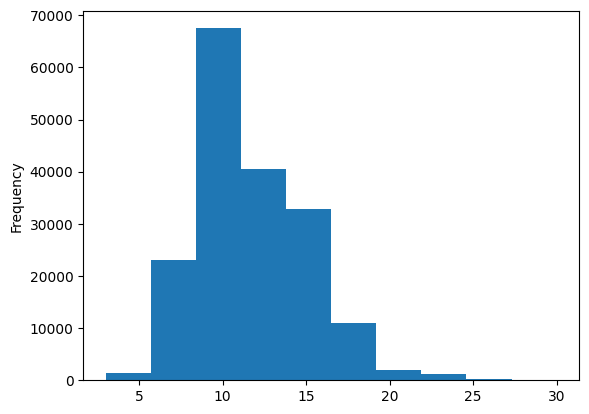

In [ ]:
train_data['total_lines'].plot.hist();

In [ ]:
print(np.percentile(a=train_data['total_lines'].values, q=90))
print(np.percentile(a=train_data['total_lines'].values, q=95))
print(np.percentile(a=train_data['total_lines'].values, q=98))

16.0
18.0
20.0


In [ ]:
train_total_lines = tf.one_hot(train_data['total_lines'], depth=20)
valid_total_lines = tf.one_hot(valid_data['total_lines'], depth=20)
test_total_lines  = tf.one_hot(test_data['total_lines'], depth=20)

train_total_lines

<tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

steps to build our model:
1. create a token-level model
2. create a character-level model
3. create a model for `line_number` feature
4. create a model for `total_lines` feature
5. combine the outputs of 1 & 2
6. combine the outputs of 3, 4 & 5
7. creating an output layer to accept the tribrid embeddings and output label probabilities
8. combine the inputs of 1, 2, 3, 4, 5 and outputs of 7 into a `keras.Model`

Model: "model_5_tribrid"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer_layer (Tex  (None, 149)                  0         ['input_5[0][0]']             
 tVectorization)                                                                                  
                                                                                                  
 USE_layer (KerasLayer)      (None, 512)                  2567978   ['input_4[0][0]'

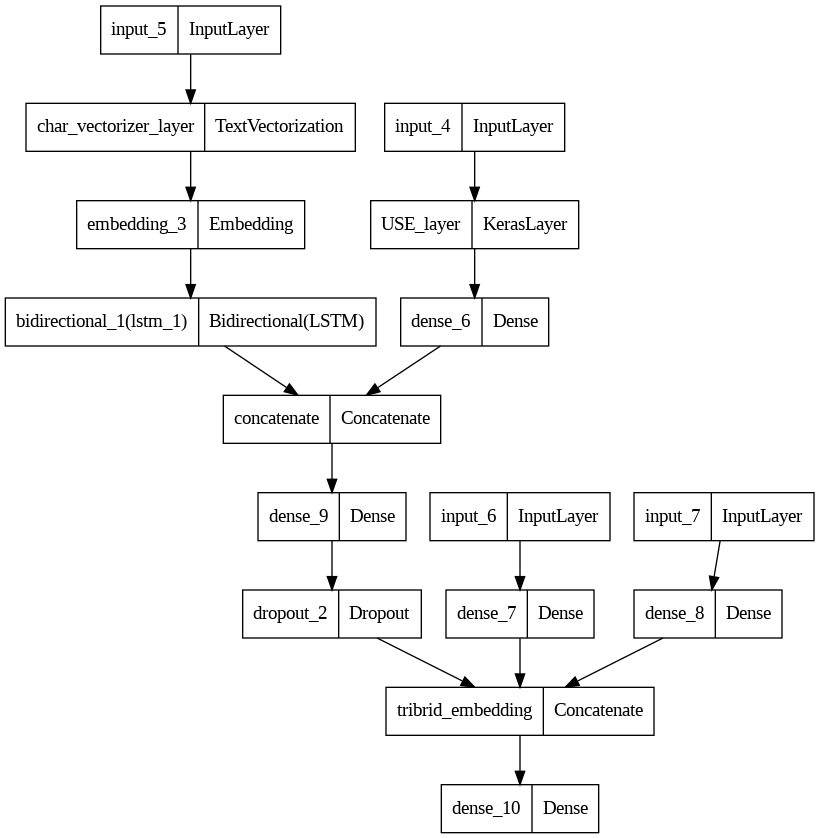

In [ ]:
# 1. token model
token_inputs = keras.layers.Input(shape=(), dtype=tf.string)
x = transfer_embedding_layer(token_inputs)
token_outputs = keras.layers.Dense(units=128, activation='relu')(x)

token_model = keras.Model(inputs=token_inputs, outputs=token_outputs, name='token_model')

# 2. char model
char_inputs = keras.layers.Input(shape=(), dtype=tf.string)
x = char_vectorizer(char_inputs)
x = keras.layers.Embedding(input_dim=len(char_vocab), output_dim=25, mask_zero=True)(x)
char_outputs = keras.layers.Bidirectional(layer=keras.layers.LSTM(units=32))(x)

char_model = keras.Model(inputs=char_inputs, outputs=char_outputs, name='char_model')

# 3. line number model
line_number_inputs = keras.layers.Input(shape=(15,))
line_number_outputs = keras.layers.Dense(units=32, activation='relu')(line_number_inputs)

line_number_model = keras.Model(inputs=line_number_inputs, outputs=line_number_outputs, name='line_number_model')

# 4. total lines model
total_lines_inputs = keras.layers.Input(shape=(20,))
total_lines_outputs = keras.layers.Dense(units=32, activation='relu')(total_lines_inputs)

total_lines_model = keras.Model(inputs=total_lines_inputs, outputs=total_lines_outputs, name='total_lines_model')

# 5. combine 1 & 2
concat_token_char_layer = keras.layers.Concatenate()([token_model.output,
                                                      char_model.output])

x = keras.layers.Dense(units=256, activation='relu')(concat_token_char_layer)
concat_token_char_outputs = keras.layers.Dropout(rate=0.5)(x)

# 6. combine 3, 4, 5
tribrid_embedding = keras.layers.Concatenate(name='tribrid_embedding')([line_number_model.output,
                                                                        total_lines_model.output,
                                                                        concat_token_char_outputs])

# 7. create output layer
output_layer = keras.layers.Dense(units=num_classes, activation='softmax')(tribrid_embedding)

# 8. constructing the model
model_5 = keras.Model(inputs=[line_number_model.input,
                              total_lines_model.input,
                              token_model.input,
                              char_model.input],
                      outputs=output_layer,
                      name='model_5_tribrid')

model_5.compile(loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=keras.optimizers.Adam(),
                metrics='accuracy')

model_5.summary()

keras.utils.plot_model(model_5)

In [ ]:
train_tribrid_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices((train_line_numbers, train_total_lines, train_sents, train_chars)),
                                             tf.data.Dataset.from_tensor_slices(train_labels))).batch(32).prefetch(tf.data.AUTOTUNE)

valid_tribrid_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices((valid_line_numbers, valid_total_lines, valid_sents, valid_chars)),
                                             tf.data.Dataset.from_tensor_slices(valid_labels))).batch(32).prefetch(tf.data.AUTOTUNE)

test_tribrid_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices((test_line_numbers, test_total_lines, test_sents, test_chars)),
                                             tf.data.Dataset.from_tensor_slices(test_labels))).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
history_model_5 = model_5.fit(train_tribrid_dataset,
                              validation_data=valid_tribrid_dataset,
                              callbacks=[keras.callbacks.TensorBoard(log_dir='logs/model_5',
                                                                     write_images=True),
                                         keras.callbacks.ModelCheckpoint(filepath='checkpoints/model_5.ckpt',
                                                                         save_best_only=True)],
                              epochs=5)

Epoch 1/5
5627/5627 [==============================] - 254s 43ms/step - loss: 0.9543 - accuracy: 0.8225 - val_loss: 0.9111 - val_accuracy: 0.8457
Epoch 2/5
5627/5627 [==============================] - 236s 42ms/step - loss: 0.9097 - accuracy: 0.8534 - val_loss: 0.9022 - val_accuracy: 0.8511
Epoch 3/5
5627/5627 [==============================] - 234s 42ms/step - loss: 0.8976 - accuracy: 0.8628 - val_loss: 0.8994 - val_accuracy: 0.8532
Epoch 4/5
5627/5627 [==============================] - 206s 37ms/step - loss: 0.8890 - accuracy: 0.8685 - val_loss: 0.9018 - val_accuracy: 0.8535
Epoch 5/5
5627/5627 [==============================] - 237s 42ms/step - loss: 0.8827 - accuracy: 0.8736 - val_loss: 0.8994 - val_accuracy: 0.8540
